### **Data Loading**

In [ ]:
# The data loading part is based on example https://www.kaggle.com/veb101/facial-expression-recognition-using-pytorch
!pip install -q torchsummary

from google.colab import files
import os

print("Upload your kaggle.json file containing your API keys")
if not os.path.exists(r"/content/fer2018.zip"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ashishpatel26/fer2018
!unzip -qq  fer2018.zip -d datasets/

Upload your kaggle.json file containing your API keys


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
 92% 89.0M/96.6M [00:01<00:00, 45.0MB/s]
100% 96.6M/96.6M [00:01<00:00, 51.4MB/s]


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
import math

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline  

In [ ]:
dataset = pd.read_csv('datasets/fer20131.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
dataset.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
# extracting pixel data from pixel column
# convert it to integer
# drop original pixel column
# add all pixels as individual column

pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

In [ ]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [ ]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

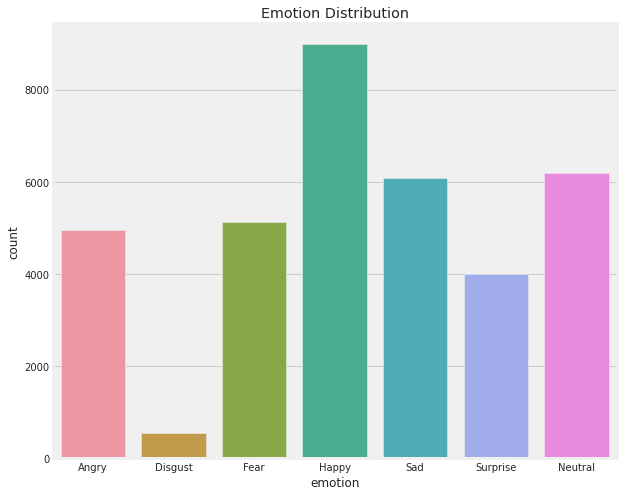

In [ ]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)], )


In [ ]:
def image_transformations() -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomCrop(48, padding=4, padding_mode='reflect'),     
        T.RandomRotation(15),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

In [ ]:
def get_train_dataset(dataframe: object, transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    return train_ds, val_ds

In [ ]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

def get_test_dataloader(dataframe: object, batch_size: int=64) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    return test_dl

In [ ]:
train_dl_un, valid_dl_un = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)
test_dl_un = get_test_dataloader(dataset)

images.shape: torch.Size([64, 1, 48, 48])


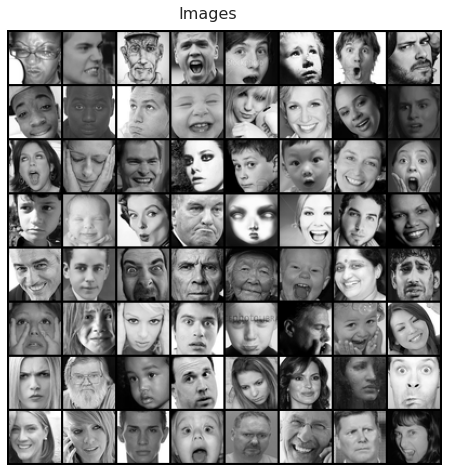

In [ ]:
for images, _ in train_dl_un:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

### **LSTM Training**

In [ ]:
# parameters 
input_dim = 48 
hidden_dim = 100
outputs_dim = 7
n_epochs = 50
batch_size = 64
layer_dim = 2

In [ ]:
# LSTM Model
class LSTM(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout = 0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = batch_size
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        return [t for t in (h0, c0)]

In [ ]:
# Training
import torch.optim as optim


# Model instance
model = LSTM(input_dim, hidden_dim, layer_dim, outputs_dim).float()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_correct= list(0. for j in range(7))
train_total= list(0. for j in range(7))
valid_correct= list(0. for j in range(7))
valid_total= list(0. for j in range(7))
train_losses, valid_losses = [],[]
train_accuracies, valid_accuracies = [],[]
valid_loss_min = np.Inf


for epoch in range(n_epochs):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    valid_running_loss = 0.0
    valid_acc = 0.0
    best_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_dl_un):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 48,48).float() 

        # forward + backward + optimize
        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        # predict the classes
        _, train_pred = torch.max(outputs,1)
        # find accuracy of each epoch
        training_correct = np.squeeze(train_pred.eq(labels.data.view_as(train_pred)))
        for k in range(len(labels)):
          label = labels.data[k]
          train_correct[label] += training_correct[k].item()
          train_total[label] += 1
         
    model.eval()
 
    
    for i, data in enumerate(valid_dl_un):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 48,48).float() 

        # forward
        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        valid_running_loss += loss.item() * inputs.size(0)
        # predict the classes
        _, valid_pred = torch.max(outputs,1)
        # find accuracy
        validation_correct = np.squeeze(valid_pred.eq(labels.data.view_as(valid_pred)))
        for k in range(len(labels)):
          label = labels.data[k]
          valid_correct[label] += validation_correct[k].item()
          valid_total[label] += 1

    trainning_loss = train_running_loss/len(train_dl_un.sampler)
    valid_loss = valid_running_loss/len(valid_dl_un.sampler)
    train_losses.append(trainning_loss)
    valid_losses.append(valid_loss)    
    train_accuracies.append(100 * np.sum(train_correct)/np.sum(train_total))
    valid_accuracies.append(100 * np.sum(valid_correct)/np.sum(valid_total))
    
    print('Epoch : {}\t Training Loss:{:.6f}\t Validation Loss:{:.6f}'.format(
        epoch,
        trainning_loss,
        valid_loss))
    if valid_loss <= valid_loss_min:
        print('Validation Loss decreased ({:.6f} --> {:.6f}), Saving Model...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(),'model.pt')
        valid_loss_min = valid_loss

Epoch : 0	 Training Loss:1.754214	 Validation Loss:1.688293
Validation Loss decreased (inf --> 1.688293), Saving Model...
Epoch : 1	 Training Loss:1.688436	 Validation Loss:1.656661
Validation Loss decreased (1.688293 --> 1.656661), Saving Model...
Epoch : 2	 Training Loss:1.646584	 Validation Loss:1.616711
Validation Loss decreased (1.656661 --> 1.616711), Saving Model...
Epoch : 3	 Training Loss:1.606136	 Validation Loss:1.576502
Validation Loss decreased (1.616711 --> 1.576502), Saving Model...
Epoch : 4	 Training Loss:1.575794	 Validation Loss:1.545943
Validation Loss decreased (1.576502 --> 1.545943), Saving Model...
Epoch : 5	 Training Loss:1.544726	 Validation Loss:1.507415
Validation Loss decreased (1.545943 --> 1.507415), Saving Model...
Epoch : 6	 Training Loss:1.518904	 Validation Loss:1.491073
Validation Loss decreased (1.507415 --> 1.491073), Saving Model...
Epoch : 7	 Training Loss:1.490363	 Validation Loss:1.456782
Validation Loss decreased (1.491073 --> 1.456782), Savin

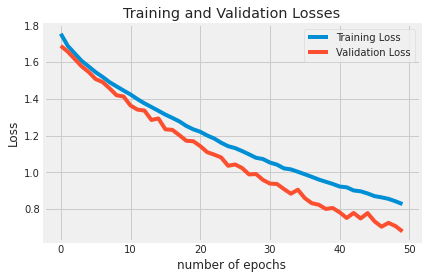

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Training and Validation Losses')
plt.ylabel('Loss')
plt.xlabel('number of epochs')
plt.legend(["Training Loss", "Validation Loss"])
plt.savefig('Training and Validation Losses')
plt.show()

### **LSTM Testing**

In [ ]:
def get_conf_matrix(y,y_pred):
  lbls = np.unique(y)
  conf_matrix =[]
  for lbl in lbls:
    idxs = np.argwhere(y==lbl).squeeze().tolist()
    (unique, counts) = np.unique(y_pred[idxs], return_counts=True)
    freq_map = dict(zip(unique, counts))
    missing_keys = [l for l in lbls if l not in list(freq_map.keys())]
    for k in missing_keys:
      freq_map.update({k: 0})
    preds = [freq_map[l] for l in lbls]
    conf_matrix.append(preds)
  return np.array(conf_matrix)

In [ ]:
class_labels = np.array(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
tag = [0,1,2,3,4,5,6]

In [ ]:
def plot_confusion_matrix(y,y_pred,class_labels = None):
  '''
  This function takes the values of TP, TN, FP and FN and plots the confusion 
  matrix as a heatmap 
  '''
  # Initialise the figure
  fig, ax = plt.subplots(figsize=(8,8))
  # Create the confusion matrix 
  conf_mat = get_conf_matrix(y,y_pred)
  # Plot the matrix as a heatmap
  im = ax.imshow(conf_mat,cmap='Blues')

  # Format plot properties
  ax.set_xticks(np.arange(conf_mat.shape[0]))
  ax.set_yticks(np.arange(conf_mat.shape[0]))

  ax.set_xticklabels(class_labels)
  ax.set_yticklabels(class_labels)

  ax.set_xlabel('Results')
  ax.set_ylabel('Ground Truth')
  ax.set_title('Confusion Matrix')

  # Add text to the heatmap
  max = np.max(conf_mat)
  for i in range(conf_mat.shape[0]):
      for j in range(conf_mat.shape[0]):
          val = conf_mat[i][j]
          if val/max < 0.5:
            text = ax.text(j, i, conf_mat[i][j],
                        ha="center", va="center", color="midnightblue")
          else:
            text = ax.text(j, i, conf_mat[i][j],
                        ha="center", va="center", color="w")

  fig.tight_layout()
  plt.show()

Test Loss: 1.606277

Test Accuracy of     0: 39% (192/491)
Test Accuracy of     1: 45% (25/55)
Test Accuracy of     2: 30% (159/528)
Test Accuracy of     3: 68% (606/879)
Test Accuracy of     4: 34% (205/594)
Test Accuracy of     5: 59% (248/416)
Test Accuracy of     6: 44% (281/626)


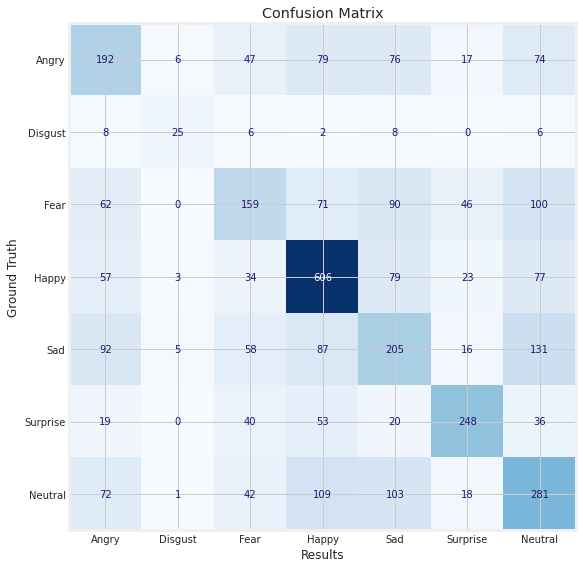


 Training Accuracy: 54% (17701/32298)

 Validation Accuracy: 58% (18996/32298)

 Test Accuracy: 47% (1716/3589)


In [ ]:
# track the test loss
test_loss = 0
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
test_accuracies = []
y_true,y_pred = [],[]
device = 'cpu'
model = model.to('cpu')

model.eval()
for images,labels in test_dl_un:
    # forward propagation
    images = images.view(-1, 48, 48)
    output = model(images)
    # calculate the loss
    loss = criterion(output,labels)
    # update the loss
    test_loss += loss.item() * images.size(0)
    # predict the classes
    _, pred = torch.max(output,1)
    for j in range(len(labels)):
      pred_array = np.array(pred)
      labels_array = np.array(labels)
      y_pred.append(pred_array[j])
      y_true.append(labels_array[j])
    # find accuracy
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        #y_pred.append(pred.data[i])
        #y_true.append(labels[i])
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print test loss
test_loss = test_loss/len(test_dl_un.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
             (str(i), 100 * class_correct[i]/class_total[i],
             np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: NA(no training examples)'% classes[i])
        
plot_confusion_matrix(np.array(y_true),np.array(y_pred), class_labels[tag])

print('\n Training Accuracy: %2d%% (%2d/%2d)' % (
     train_accuracies[-1], np.sum(train_correct)/n_epochs, np.sum(train_total)/n_epochs))

print('\n Validation Accuracy: %2d%% (%2d/%2d)' % (
     valid_accuracies[-1], np.sum(valid_correct)/n_epochs, np.sum(valid_total)/n_epochs))

print('\n Test Accuracy: %2d%% (%2d/%2d)' % (
     100 * np.sum(class_correct)/np.sum(class_total),
             np.sum(class_correct), np.sum(class_total)))